# Sentiment Analyis

#### Menggunakan Pretrained Dataset Bert dan Scraping tweet dengan Twint <br>
================================= <br>
&nbsp;Digunakan untuk Tugas Pemrosesan Bahasa Alami <br>
================================= <br>
Akbar Sigit Putra &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 20/463490/TK/51582 <br>
Wiweka Yoga Sadewa  20/456382/TK/50512

In [1]:
# Uncomment Jika tidak memiliki library

# !pip install tweepy
# !pip install spacy
# !pip install textblob
# !pip install Sastrawi
# !pip install nest_asyncio
# !pip install wordcloud
# !pip install transformers 
# !pip install torch
# !pip install --user --upgrade git+https://github.com/twintproject/twint.git@origin/master#egg=twint

# A. Membuat Model

## Dataset dan Modul

In [2]:
# Library yang Digunakan

import re
import nltk
import torch
import requests
import Sastrawi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import json
import datetime
import random
import seaborn as sns
import sklearn.metrics as skm
import itertools
import twint
import nest_asyncio  
nest_asyncio.apply()

from nltk import word_tokenize
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.corpus import stopwords
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split
from sklearn.metrics import accuracy_score, confusion_matrix
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [3]:
# Jika File ada di Gdrive
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# Datase Yang Digunakan

path = "/content/gdrive/MyDrive/Dataset-Sentimen-Analisis"

data1 = pd.read_csv(path + '/dataset_komentar_instagram_cyberbullying.csv')
data2 = pd.read_csv(path + '/dataset_tweet_sentimen_tayangan_tv.csv')
data3 = pd.read_csv(path + '/dataset_tweet_sentiment_cellular_service_provider.csv')
data4 = pd.read_csv(path + '/dataset_tweet_sentiment_opini_film.csv')
data5 = pd.read_csv(path + '/dataset_tweet_sentiment_pilkada_DKI_2017.csv')

In [5]:
# Drop dan Rename Column

data1.drop(columns=['Id'], inplace=True)
data1.rename(columns={'Instagram Comment Text': 'Tweet'}, inplace=True)

data2.drop(columns=['Id', 'Acara TV', 'Jumlah Retweet'], inplace=True)
data2.rename(columns={'Text Tweet': 'Tweet'}, inplace=True)

data3.drop(columns=['Id'], inplace=True)
data3.rename(columns={'Text Tweet': 'Tweet'}, inplace=True)

data4.drop(columns=['Id'], inplace=True)
data4.rename(columns={'Text Tweet': 'Tweet'}, inplace=True)

data5.drop(columns=['Id', 'Pasangan Calon'], inplace=True)
data5.rename(columns={'Text Tweet': 'Tweet'}, inplace=True)

In [6]:
# Menggabungkan Dataset

data = pd.concat([data1, data2, data3, data4, data5], ignore_index=True)
data

,Sentiment,Tweet
0,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,negative,Geblek lo tata...cowo bgt dibela2in balikan......
2,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."
...,...,...
2195,positive,"Kali saja bpk @aniesbaswedan @sandiuno lihat, ..."
2196,positive,Kita harus dapat merangkul semua orang tanpa b...
2197,positive,Ini jagoanku dibidang digital <Smiling Face Wi...
2198,positive,#PesanBijak #OkeOce #GubernurGu3 ...


In [7]:
# Stopword

# Dari NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk_stopword = stopwords.words('indonesian')

# Dari Sastrawi
sastrawi_stopword_path = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-list/sastrawi-stopwords.txt"
response = requests.get(sastrawi_stopword_path)
sastrawi_stopword = response.text.split('\n')

# Combine
stopwords = nltk_stopword + sastrawi_stopword
stopwords = set(stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
# Reading Slang data from the file
with open(path+"/slang.txt") as f:
    slang = f.read()
slang = json.loads(slang)

In [9]:
# WordCloud

def wordcloud(result, sentiment, emotion, tweet):
  result_data = result.loc[result[sentiment] == emotion]
  result_data

  allWords  = ' '.join( [str (twts) for twts in result_data[tweet]])
  wordCloud = WordCloud(width = 1000, height=800, random_state=123, max_font_size=400).generate(allWords)

  plt.imshow(wordCloud, interpolation= 'bilinear')
  plt.axis('off')
  plt.show()

In [10]:
# Preprocessing

def cleaning_text(text):
    #Remove Special Character
    text = re.sub(r'[!,*)#%(&$_?.:]+<>^', '', text)
    #Remove Tag Account
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'USERNAME', '', text)
    #Remove Hastag
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    # Remove retweet
    text = re.sub(r'RT[\s]+', '', text)
    # Remove link
    text = re.sub(r'https?:\/\/\S+', '', text)
    text = text.strip()
    text = text.lower()
    return text

def remove_stopword(text, stopwords = stopwords):
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stopwords]
    return ' '.join(filtered_sentence)

def stemming_and_lemmatization(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return stemmer.stem(text)

def remove_slang_akronim(text, slang = slang):
    text = ''.join(slang[p] if p in slang else p for p in re.split(r'(\W+)', text))
    return text

def preprocess(text):
    # cleaning text and lowercase
    output = cleaning_text(text)
    # remove stopwords
    output = remove_stopword(output)
    # remove slang
    output = remove_slang_akronim(output)
    # stemming and lemmatization
    output = stemming_and_lemmatization(output)
    
    return output

In [11]:
preprocessed_data = data.copy()
preprocessed_data['Tweet'] = data['Tweet'].map(preprocess)

In [12]:
preprocessed_data['Tweet'][0]

'tolol gak hubung nya gugur dengan pakai hijab syar i yang kamu bilang bayi nya panas dalem gak hubung nya woyyyy otak jempol kamu gak singkron sih nulis komentar'

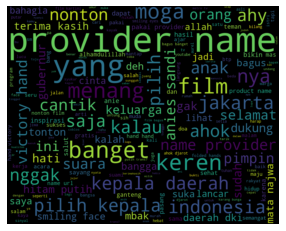

In [13]:
#get positif data
wordcloud(preprocessed_data, 'Sentiment', 'positive', 'Tweet')

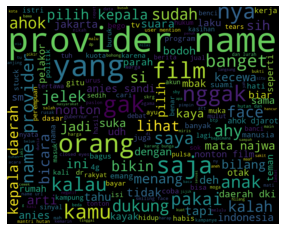

In [14]:
#get negatif data
wordcloud(preprocessed_data, 'Sentiment', 'negative', 'Tweet')

## Tokenization and Input Formatting

### Bert Tokenizer

In [15]:
preprocessed_data['Sentiment'].replace(['negative','positive'], ['0','1'],inplace = True)
preprocessed_data

,Sentiment,Tweet
0,0,tolol gak hubung nya gugur dengan pakai hijab ...
1,0,geblek kamu tata cowo banget dibela2in balik h...
2,0,kemarin termewek2 sekarang lengket lagi duhhh ...
3,0,inti kesel att nya gausah anak kasi kembang ps...
4,0,hadewwwww permpuan lagi sakit jiwa kenapa yang...
...,...,...
2195,1,kali bapak lihat rspun selfie hand
2196,1,rangkul orang batas usia kelamin hand victory ...
2197,1,jago bidang digital smiling face with sunglass...
2198,1,


In [16]:
# Get labeled data sets for the training later

sentences = preprocessed_data['Tweet'].values
labels = preprocessed_data['Sentiment'].astype(int).values

In [17]:
# Load the BERT tokenizer.

tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-large-p2', do_lower_case=True)

### Tokenized Datasets

In [18]:
# Import Torch dan cek Cuda jika punya gpu

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [19]:
# Tokenize

def tokenize(sentences):
    input_ids = []
    attention_masks = []

    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
                        sent,                         # Sentence to encode.
                        add_special_tokens = True,    # Add '[CLS]' and '[SEP]'
                        max_length = 51,              # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True, # Construct attn. masks.
                        return_tensors = 'pt',        # Return pytorch tensors.
                       )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    return input_ids, attention_masks

In [20]:
# Tokenize all of the sentences and map the tokens to their word IDs.

input_ids, attention_masks = tokenize(sentences)
labels = torch.tensor(labels)
# Contoh Sentence 0, juga dalam list IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  tolol gak hubung nya gugur dengan pakai hijab syar i yang kamu bilang bayi nya panas dalem gak hubung nya woyyyy otak jempol kamu gak singkron sih nulis komentar
Token IDs: tensor([    2, 29190,  1489, 23789,  1107, 10877,    79,  2468,  8101,  9060,
           89,    34,   508,  2911,  1625,  1107,  1990, 14938,  1489, 23789,
         1107, 11479, 16803, 16803,  2965, 14070,   508,  1489,  7633,  3802,
         1966, 11504,  2565,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0])


In [21]:
# Combine the training inputs into a TensorDataset.

dataset = TensorDataset(input_ids, attention_masks, labels.long())

# Create a 90-10 train-validation split.
# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

1,760 training samples
  440 validation samples


In [22]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [23]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top.

model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-large-p2', 
            num_labels = 2
        )

# Use the 12-layer indobertmodel for tweet, uncased
# The number of output labels--3 for netral negatif positif classification.
# You can increase this for multi-class tasks.   
# output_attentions = False, # Whether the model returns attentions weights.
# output_hidden_states = False, # Whether the model returns all hidden-states.
# ignore_mismatched_sizes=True

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-large-p2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# See Model Summary.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1

In [25]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


### Train loop

In [26]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# Further reading: https://arxiv.org/pdf/1810.04805.pdf

epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [27]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

## Helper function for formatting elapsed times as `hh:mm:ss`
def format_time(elapsed):
    # Takes a time in seconds and returns a string hh:mm:ss
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [28]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

loss_values = []
y_true_val=[]
y_pred_val = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        if epoch_i==epochs-1:
          y_pred_val.append(logits)
          y_true_val.append(label_ids)
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    110.    Elapsed: 0:00:22.
  Batch    80  of    110.    Elapsed: 0:00:44.

  Average training loss: 0.46
  Training epcoh took: 0:01:01

Running Validation...
  Accuracy: 0.87
  Validation Loss: 0.36
  Validation took: 0:00:05

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    110.    Elapsed: 0:00:23.
  Batch    80  of    110.    Elapsed: 0:00:47.

  Average training loss: 0.21
  Training epcoh took: 0:01:05

Running Validation...
  Accuracy: 0.89
  Validation Loss: 0.38
  Validation took: 0:00:06

Training complete!
Total training took 0:02:16 (h:mm:ss)


In [29]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data = training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.46,0.36,0.87,0:01:01,0:00:05
2,0.21,0.38,0.89,0:01:05,0:00:06


### Train Summary

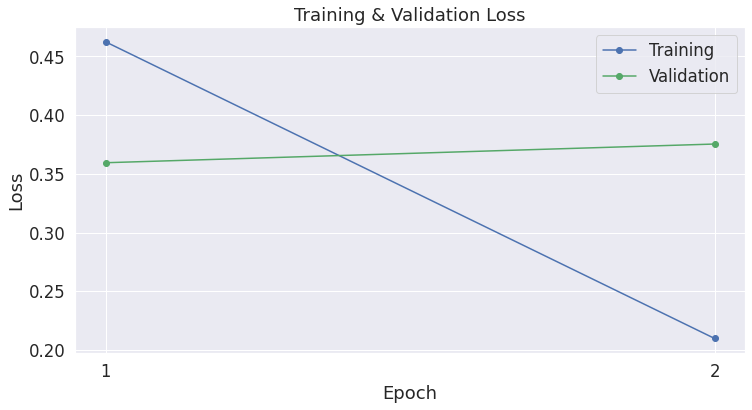

In [47]:
%matplotlib inline

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2])
plt.show()

### Akurasi

In [31]:
y_pred_val = np.concatenate(y_pred_val, axis=0)
y_pred_val = np.argmax(y_pred_val, axis=1).flatten()
y_true_val = np.concatenate(y_true_val, axis=0)

cm = skm.multilabel_confusion_matrix(y_true_val, y_pred_val)
print(skm.classification_report(y_true_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       234
           1       0.88      0.87      0.88       206

    accuracy                           0.89       440
   macro avg       0.89      0.89      0.89       440
weighted avg       0.89      0.89      0.89       440



In [32]:
# Citiation http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(cm, target_names, title="Confusion matrix", cmap=None, normalize=True):
  accuracy = np.trace(cm) / float(np.sum(cm))
  misclass = 1 - accuracy

  if cmap is None:
    cmap = plt.get_cmap("Blues")

  plt.figure(figsize=(8, 6))
  plt.imshow(cm, interpolation="nearest", cmap=cmap)
  plt.title(title)
  plt.colorbar()

  if target_names is not None:
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

  if normalize:
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

  thresh = cm.max() / 1.5 if normalize else cm.max() / 2

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if normalize:
      plt.text(
        j,
        i,
        "{:0.4f}".format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
      )
    else:
      plt.text(
        j,
        i,
        "{:,}".format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
      )

  plt.tight_layout()

  plt.ylabel("Predicted label")

  plt.xlabel(
    "True label\naccuracy={:0.4f}; misclass={:0.4f}".format(accuracy, misclass)
  )

  plt.show()

Accuracy Random Forest Classifier:  0.8863636363636364


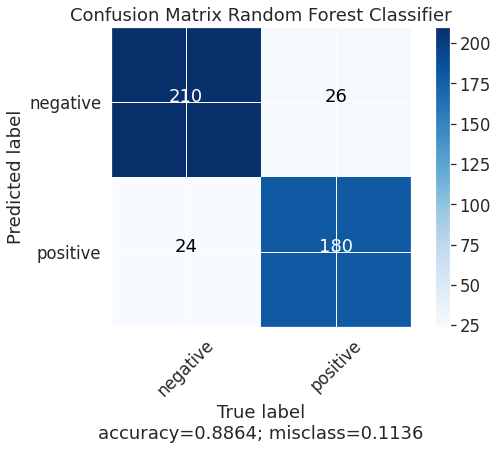

In [33]:
print('Accuracy Random Forest Classifier: ', accuracy_score(y_true_val, y_pred_val))
plot_confusion_matrix(cm           = confusion_matrix(y_pred_val, y_true_val), 
                      normalize    = False,
                      target_names = ['negative', 'positive'],
                      title        = "Confusion Matrix Random Forest Classifier")

# B. Cek Trend dengan Unlabeled Data

### Generate Tweet

In [48]:
# Scraping with Twint
c = twint.Config()
c.Search = "Baim Wong"
c.Lang = 'in'
c.Since = '2022-09-26'
c.Until = '2022-10-09'
c.Count = True
c.Retweets = False
c.Stats = False
c.Show_hashtags = False
c.Hide_output = False
c.Profile_full = False
c.Store_csv = True
c.Links = 'include'
c.Output = path+'/tweet_data.csv'
twint.run.Search(c)

1578891325172174849 2022-10-08 23:33:20 +0000 <Newstagar> Polisi Dalami Pengakuan Edukasi Masyarakat dari Baim Wong Terkait Konten Prank KDRT  https://t.co/iKCObSaNQK
1578890743003123712 2022-10-08 23:31:02 +0000 <tauberitamedia> Baim Wong mengaku tak ada niatan menjelekkan institusi polisi di konten prank KDRT. Niatan Baim membuat konten tersebut hanya ingin mengedukasi.  https://t.co/RhPpLVs3eG
1578842321302716418 2022-10-08 20:18:37 +0000 <_iFad> Baim Wong melihat berita ini:  https://t.co/yILkI5tQsc
1578836255194116096 2022-10-08 19:54:31 +0000 <Citayam_FW> Kronologi Lengkap Prank KDRT Baim Wong Hinga Klaim untuk Edukasi #citayamfashionweek #cfw  https://t.co/a4Zimvd5em
1578836241570680835 2022-10-08 19:54:28 +0000 <Citayam_FW> Disebut tak belajar dari pengalaman, Warganet bosan liat Baim Wong dan Paula ... #citayamfashionweek #cfw  https://t.co/l6af4TPEhG
1578830095946420224 2022-10-08 19:30:02 +0000 <Genpi_Co> Kasus prank KDRT yang dilakukan Baim Wong dan istrinya, Paula Verhoeve

In [49]:
scraping_data = pd.read_csv(path+'/tweet_data.csv')
data = pd.DataFrame(scraping_data['tweet'])
data

,tweet
0,Polisi Dalami Pengakuan Edukasi Masyarakat dar...
1,Baim Wong mengaku tak ada niatan menjelekkan i...
2,Baim Wong melihat berita ini: https://t.co/yI...
3,Kronologi Lengkap Prank KDRT Baim Wong Hinga K...
4,"Disebut tak belajar dari pengalaman, Warganet ..."
...,...
4515,"Dia di Facebook ya,mamak ku di suruh isi form ..."
4516,PENIPU BAWA BAWA NAMA BAIM WONG THREAD☝️ Mama...
4517,ini baim wong ikutan bahas bilar ama si lesti???
4518,Mirip baim wong


In [50]:
#Clean Text

data['tweet'] = data['tweet'].apply(cleaning_text)
data

,tweet
0,polisi dalami pengakuan edukasi masyarakat dar...
1,baim wong mengaku tak ada niatan menjelekkan i...
2,baim wong melihat berita ini:
3,kronologi lengkap prank kdbaim wong hinga klai...
4,"disebut tak belajar dari pengalaman, warganet ..."
...,...
4515,"dia di facebook ya,mamak ku di suruh isi form ..."
4516,penipu bawa bawa nama baim wong thread☝️ mama...
4517,ini baim wong ikutan bahas bilar ama si lesti???
4518,mirip baim wong


In [51]:
prediction_sentences = data['tweet'].values

## Make Prediction

In [52]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids, attention_masks = tokenize(prediction_sentences)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler = prediction_sampler, batch_size = batch_size)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [53]:
def predic(prediction_dataloader):
    # Tracking variables 
    predictions = []

    # Predict 
    for batch in prediction_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)

      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask = batch

      # Telling the model not to compute or store gradients, saving memory and 
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, token_type_ids=None, 
                          attention_mask=b_input_mask)

      logits = outputs[0]

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()

      # Store predictions and true labels
      predictions.append(logits)

    return predictions

In [54]:
# Prediction on test set
print('Predicting labels for {:,} test sentences'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()
predictions = predic(prediction_dataloader)

Predicting labels for 4,520 test sentences


In [55]:
def positif_group(x):
  if x == 1:
    return "positive"
  else:
    return "negative"

In [56]:
np.shape(predictions)
predictions = np.concatenate(predictions, axis=0)
data_result = pd.DataFrame(predictions, columns=['negative', 'positive'])
dfhasilpredict = data_result.eq(data_result.where(data_result != 0).max(1), axis=0).astype(int)
dfhasilpredict['Analysis'] = dfhasilpredict['positive'].apply(positif_group)
dfhasilpredict

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


,negative,positive,Analysis
0,1,0,negative
1,1,0,negative
2,1,0,negative
3,1,0,negative
4,1,0,negative
...,...,...,...
4515,1,0,negative
4516,1,0,negative
4517,1,0,negative
4518,0,1,positive


In [57]:
finalresult = pd.concat([data, dfhasilpredict], axis=1, sort=False)
finalresult

,tweet,negative,positive,Analysis
0,polisi dalami pengakuan edukasi masyarakat dar...,1,0,negative
1,baim wong mengaku tak ada niatan menjelekkan i...,1,0,negative
2,baim wong melihat berita ini:,1,0,negative
3,kronologi lengkap prank kdbaim wong hinga klai...,1,0,negative
4,"disebut tak belajar dari pengalaman, warganet ...",1,0,negative
...,...,...,...,...
4515,"dia di facebook ya,mamak ku di suruh isi form ...",1,0,negative
4516,penipu bawa bawa nama baim wong thread☝️ mama...,1,0,negative
4517,ini baim wong ikutan bahas bilar ama si lesti???,1,0,negative
4518,mirip baim wong,0,1,positive


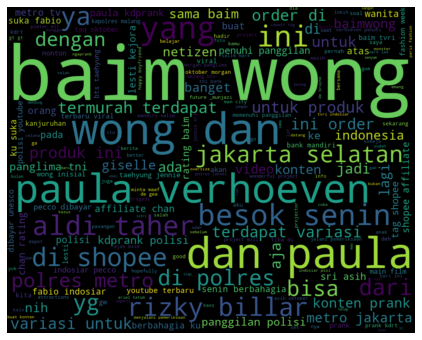

In [58]:
#get positif data
wordcloud(finalresult, 'Analysis', 'positive', 'tweet')

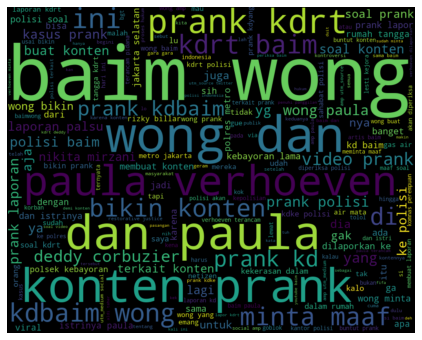

In [59]:
#get negatif data
wordcloud(finalresult, 'Analysis', 'negative', 'tweet')

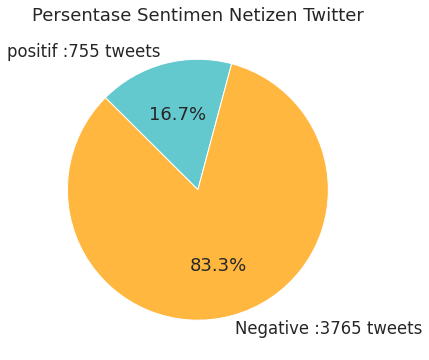

In [60]:
sent_positive = finalresult['positive'].sum()
sent_negative = finalresult['negative'].sum()
warna = ['#64C9CF','#FFB740']
labels = ['positif :'+ str(sent_positive) +" tweets", "Negative :" + str(sent_negative) +" tweets"]
sizes = [sent_positive, sent_negative]

plt.pie(sizes, labels=labels, autopct ='%1.1f%%',colors=warna,startangle=75)
plt.title("Persentase Sentimen Netizen Twitter")
plt.show()